# AI 04.1 Solubility

> 학번: 2019452068
>
> 이름: 박규선

---


### 1. Prepare Data

---

#### Solubility Data

Tetko et al. (2001) and Huuskonen (2000) investigated a set of compounds with corresponding experimental solubility values using complex sets of descriptors. They used linear regression and neural network models to estimate the relationship between chemical structure and solubility. For our analyses, we will use 1267 compounds and a set of more understandable descriptors that fall into one of three groups: 208 binary "fingerprints" that indicate the presence or absence of a particular chemical sub-structure, 16 count descriptors (such as the number of bonds or the number of Bromine atoms) and 4 continuous descriptors (such as molecular weight or surface area).

1267 observation (951+316)

228 mixed variables

https://www.rdocumentation.org/packages/AppliedPredictiveModeling/versions/1.1-6/topics/solubility

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os


In [2]:
!mkdir dataset
!wget -O 'dataset/solTestX.csv' https://ycs-class.s3.ap-northeast-2.amazonaws.com/dataset/solTestX.csv
!wget -O 'dataset/solTestY.csv' https://ycs-class.s3.ap-northeast-2.amazonaws.com/dataset/solTestY.csv
!wget -O 'dataset/solTrainX.csv' https://ycs-class.s3.ap-northeast-2.amazonaws.com/dataset/solTrainX.csv
!wget -O 'dataset/solTrainY.csv' https://ycs-class.s3.ap-northeast-2.amazonaws.com/dataset/solTrainY.csv    

--2019-10-09 01:41:58--  https://ycs-class.s3.ap-northeast-2.amazonaws.com/dataset/solTestX.csv
Resolving ycs-class.s3.ap-northeast-2.amazonaws.com (ycs-class.s3.ap-northeast-2.amazonaws.com)... 52.219.56.51
Connecting to ycs-class.s3.ap-northeast-2.amazonaws.com (ycs-class.s3.ap-northeast-2.amazonaws.com)|52.219.56.51|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 215968 (211K) [text/csv]
Saving to: ‘dataset/solTestX.csv’

dataset/solTestX.cs 100%[===================>] 210.91K   380KB/s    in 0.6s    

2019-10-09 01:41:59 (380 KB/s) - ‘dataset/solTestX.csv’ saved [215968/215968]

--2019-10-09 01:42:00--  https://ycs-class.s3.ap-northeast-2.amazonaws.com/dataset/solTestY.csv
Resolving ycs-class.s3.ap-northeast-2.amazonaws.com (ycs-class.s3.ap-northeast-2.amazonaws.com)... 52.219.56.51
Connecting to ycs-class.s3.ap-northeast-2.amazonaws.com (ycs-class.s3.ap-northeast-2.amazonaws.com)|52.219.56.51|:443... connected.
HTTP request sent, awaiting response... 200 O

In [3]:
data = {}
f_list = ["solTestX", "solTestY", "solTrainX", "solTrainY"]

for fname in f_list :
    data[fname] = pd.read_csv("dataset/{}.csv".format(fname), index_col=0)
    
print("Data Loaded")

Data Loaded


In [4]:
train_data = data["solTrainX"]
train_label = data["solTrainY"]
test_data = data["solTestX"]
test_label = data["solTestY"]

print("train data : ", train_data.shape)
print("train label : ", train_label.shape)
print("test data : ", test_data.shape)
print("test label : ", test_label.shape)

arr = train_data.columns

train data :  (951, 228)
train label :  (951, 1)
test data :  (316, 228)
test label :  (316, 1)


In [5]:
data["solTestX"].head()

,FP001,FP002,FP003,FP004,FP005,FP006,FP007,FP008,FP009,FP010,FP011,FP012,FP013,FP014,FP015,FP016,FP017,FP018,FP019,FP020,FP021,FP022,FP023,FP024,FP025,FP026,FP027,FP028,FP029,FP030,FP031,FP032,FP033,FP034,FP035,FP036,FP037,FP038,FP039,FP040,...,FP189,FP190,FP191,FP192,FP193,FP194,FP195,FP196,FP197,FP198,FP199,FP200,FP201,FP202,FP203,FP204,FP205,FP206,FP207,FP208,MolWeight,NumAtoms,NumNonHAtoms,NumBonds,NumNonHBonds,NumMultBonds,NumRotBonds,NumDblBonds,NumAromaticBonds,NumHydrogen,NumCarbon,NumNitrogen,NumOxygen,NumSulfer,NumChlorine,NumHalogen,NumRings,HydrophilicFactor,SurfaceArea1,SurfaceArea2
20,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.559126,2.197225,1.791759,2.079442,1.898648,0.798770,0.000000,0.567077,0.00000,1.719055,1.301297,0.000000,1.098612,0.0,0.375,0.375,0.000000,0.416563,8.245324,8.245324
21,1,0,1,1,0,1,0,0,0,0,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,4.501031,2.639057,1.945910,2.564949,2.154845,0.798770,1.098612,0.567077,0.00000,2.886887,1.719055,0.456826,1.098612,0.0,0.000,0.000,0.000000,0.915006,9.765805,9.765805
23,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,4.710611,2.708050,2.197225,2.708050,2.759228,2.944766,0.000000,0.000000,1.94591,2.642633,2.642633,0.000000,1.098612,0.0,0.000,0.000,0.693147,0.652185,8.591537,8.591537
25,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,4.617000,2.995732,2.079442,2.995732,2.578583,0.000000,0.000000,0.000000,0.00000,3.862179,2.372566,0.584815,0.000000,0.0,0.000,0.000,0.693147,0.734273,6.568437,6.568437
28,1,1,0,1,1,1,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.813322,2.772589,2.302585,2.772589,2.924466,3.243492,0.693147,0.567077,1.94591,2.642633,2.642633,0.584815,0.693147,0.0,0.000,0.000,0.693147,0.650346,10.095894,10.095894


In [0]:
train_x, train_y = train_data.values, train_label.values
test_x, test_y = test_data.values, test_label.values

### 2. Define Model

---

In [0]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [0]:
def mse_loss(y_hat, y):
    return np.mean( (y_hat-y)**2 )

In [0]:
def numerical_gradient(f, x):
    h = 0.0001
    grad = np.zeros_like(x)
    
    it = np.nditer(x, flags=['multi_index'])
    while not it.finished:
        idx = it.multi_index
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x) # f(x+h)
        
        x[idx] = tmp_val - h 
        fxh2 = f(x) # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)
        
        x[idx] = tmp_val
        it.iternext()   
        
    return grad

In [0]:

class SingleLayerNet:

    def __init__(self, input_size, output_size, weight_init_std=0.01):
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, output_size)
        self.params['b1'] = np.zeros(output_size)

    def predict(self, x):
        W1 = self.params['W1']
        b1 = self.params['b1']
    
        # Edit this
        a1 = np.dot(x, W1) + b1
        
        y = a1

        return y
        
    def loss(self, x, y):
        y_hat = self.predict(x)
  
        return mse_loss(y_hat, y) # Edit this MSE
    
    def n_gradient(self, x, y):
        loss_W = lambda W: self.loss(x, y)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        
        return grads

    def accuracy(self, x, y):
        
        y_hat = self.predict(x)
        
        sum_residuals = np.sum( (y - y_hat) **2 )
        sum_squares = np.sum( (y - np.mean(y)) **2 )
        
        return 1 - (sum_residuals / sum_squares)

### 3. Train Model

---

In [11]:
learning_rate = 0.001

net = SingleLayerNet(train_x.shape[1], 1)

train_loss_list = []
train_acc_list = []
test_acc_list = []

for i in range(3000):
    
    # 기울기 계산
    grad = net.n_gradient(train_x, train_y)
    
    # 매개변수 갱신    
    for key in net.params:
        net.params[key] -= learning_rate * grad[key]
                
    # 학습 경과 기록
    loss = net.loss(train_x, train_y)
    train_loss_list.append(loss)
    
    # 정확도 출력    
    if i % 50 == 0:
        train_acc = net.accuracy(train_x, train_y)
        test_acc = net.accuracy(test_x, test_y)
        print('iter: {} loss: {} train acc: {} test acc: {}'.format(i, loss, train_acc, test_acc ))
        train_acc_list.append( train_acc )
        test_acc_list.append( test_acc )
        


iter: 0 loss: 6.529492848689413 train acc: -0.5604609623690409 test acc: -0.6279181327453123
iter: 50 loss: 1.8228172911825933 train acc: 0.5643711861951657 test acc: 0.568388718203169
iter: 100 loss: 1.5822678191784738 train acc: 0.6218592743636451 test acc: 0.6301032885801391
iter: 150 loss: 1.4407703145870996 train acc: 0.6556752746724275 test acc: 0.6641237711837282
iter: 200 loss: 1.3257414032124493 train acc: 0.6831656372325119 test acc: 0.6912099687345201
iter: 250 loss: 1.2298406465551341 train acc: 0.7060846281087222 test acc: 0.7135438990198687
iter: 300 loss: 1.1490971277105329 train acc: 0.7253812430283019 test acc: 0.7321317189390659
iter: 350 loss: 1.0806103082536938 train acc: 0.7417486716595569 test acc: 0.7476904409010395
iter: 400 loss: 1.0221324213064025 train acc: 0.7557241000515789 test acc: 0.7607805894916487
iter: 450 loss: 0.9718830886601552 train acc: 0.767733014648262 test acc: 0.771849706961877
iter: 500 loss: 0.9284371522625823 train acc: 0.7781160090542654 

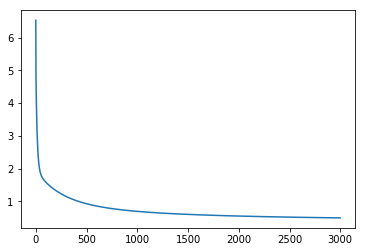

In [12]:
plt.plot(train_loss_list)
plt.show()

#### Mini-batch Version

In [13]:
learning_rate = 0.001
num_epochs = 1000
batch_size = 100

num_batches_per_epoch = max(train_x.shape[0] // batch_size, 1)
print('num_batches_per_epoch:', num_batches_per_epoch)

net = SingleLayerNet(train_x.shape[1], 1)

train_loss_list = []

for e in range(num_epochs):

    for b in range(num_batches_per_epoch):
        
        # 미니배치
        batch_mask = np.random.choice(train_x.shape[0], batch_size)
        batch_x = train_x[batch_mask] # Edit this
        batch_y = train_y[batch_mask] # Edit this

        # 기울기
        grad = net.n_gradient(batch_x, batch_y)

        # 매개변수 갱신
        for key in net.params:
            net.params[key] -= learning_rate * grad[key] # Edit this

        # 학습 경과 기록
        loss = net.loss(batch_x, batch_y)
        train_loss_list.append(loss)
    
    if e % 50 == 0:
        print('epoch: {} loss: {}'.format(e, loss))




num_batches_per_epoch: 9
epoch: 0 loss: 5.10154232767093
epoch: 50 loss: 0.8355449374624319
epoch: 100 loss: 0.7459486078856152
epoch: 150 loss: 0.4600170276307745
epoch: 200 loss: 0.6341949976647713
epoch: 250 loss: 0.478346415395697
epoch: 300 loss: 0.5140202769298003
epoch: 350 loss: 0.39338528902051306
epoch: 400 loss: 0.39881566484740366
epoch: 450 loss: 0.5858704446745783
epoch: 500 loss: 0.3768302643106556
epoch: 550 loss: 0.37641795172368775
epoch: 600 loss: 0.49290513967039223
epoch: 650 loss: 0.3595477535489253
epoch: 700 loss: 0.3059759834931956
epoch: 750 loss: 0.3996773536235698
epoch: 800 loss: 0.6132900972080232
epoch: 850 loss: 0.38045060367711286
epoch: 900 loss: 0.4387824247458528
epoch: 950 loss: 0.32697903122252386


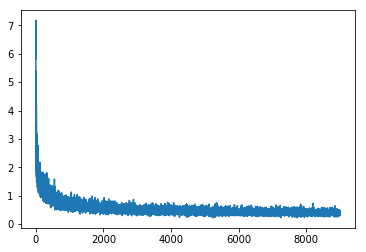

In [14]:
plt.plot(train_loss_list)
plt.show()

### 4. Test Model

---

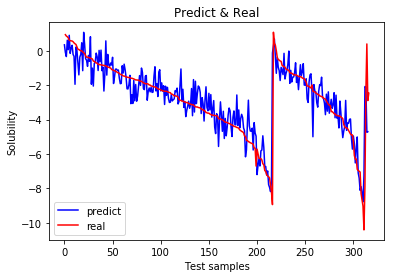

In [18]:
test_y = net.predict(test_x)

plt.title('Predict & Real')
plt.xlabel('Test samples')
plt.ylabel('Solubility')

plt.plot(test_y, 'b-', label='predict') 
plt.plot(test_label, 'r-', label='real')
plt.legend()
plt.show()